In [36]:
JIDT_HOME='/home/jovyan/notebooks/jidt'

In [74]:
#---------------------------------------------------
# START JVM
#-----------------------------------------------------

from jpype import startJVM, isJVMStarted, getDefaultJVMPath, JArray, JInt, JPackage, shutdownJVM, JDouble
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/jovyan/notebooks/jidt/demos/python")
import readIntsFile, readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
if (not isJVMStarted()):
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)


In [80]:
# LOAD DATA FILE
#-------------------

import pandas as pd
#from pathlib import Path

filename = './data/SFI-heartRate_breathVol_bloodOx-extract.txt'
data = pd.read_csv(filename, delim_whitespace=True, comment='%', header=None, names = ['Heart rate', 'Chest volume', 'Blood oxygen'], index_col=None)
data.head()

,Heart rate,Chest volume,Blood oxygen
0,83.66,7485,5042
1,85.23,12553,4881
2,86.87,13031,4822
3,88.33,17247,4762
4,87.61,12586,4744


In [39]:
data['Heart rate']

0       83.66
1       85.23
2       86.87
3       88.33
4       87.61
        ...  
1196    75.25
1197    70.13
1198    66.93
1199    65.75
1200    64.83
Name: Heart rate, Length: 1201, dtype: float64

In [20]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
#axs.plot(data['Heart rate'], label='Heart rate')
axs.plot(data['Chest volume'], label='Chest volume')
#axs.plot(data['Blood oxygen'], label='Blood oxygen')
axs.set_title('Heart rate, Chest Volume and Blood Oxygen vs Time')
axs.set_xlabel('Sample index')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

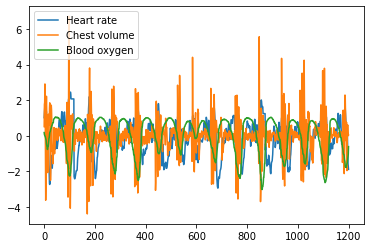

In [15]:
# Standardize the data
# ----------------------

# copy the data
data_scaled = data.copy()
  
# apply normalization techniques
for column in data_scaled.columns:
    data_scaled[column] = (data_scaled[column] -
                           data_scaled[column].mean()) / data_scaled[column].std()    
  
# view normalized data   
data_scaled.plot()

In [81]:
# Select data source and destination for MI Estimation
# ----------------------------------------------------

import numpy as np
source = data['Heart rate'].to_numpy()
destination = data['Chest volume'].to_numpy()


In [75]:

# # 0. Load/prepare the data:
# dataRaw = readFloatsFile.readFloatsFile(JIDT_HOME + "/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# # As numpy array:
# data = numpy.array(dataRaw)
# source = data[:,0]
# destination = data[:,1]

In [82]:
# Conversion to Java double array instead of numpy.float
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

In [83]:
# Construct the calculator : MI Gaussian Estimator
#-------------------------------------------------

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("TIME_DIFF", "5")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Gaussian(col_0 -> col_1) = %.4f nats" %
    (result))


MI_Gaussian(col_0 -> col_1) = 0.0015 nats


In [86]:
results=[]
def gaussianEstimator(timediff: int):
    calc.setProperty("TIME_DIFF", str(timediff))
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

for timediff in range(50):
    result=gaussianEstimator(timediff)
    results.append(result)

    

In [87]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot([t for t in range(50)], results, label='MI Gaussian')
axs.set_title('MI Gaussian Heart rate; Chest Volume vs Time Lag')
axs.set_xlabel('Time Lag')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
#------------------------------------------
# Estimation with Kraskov KSG Estimator
#------------------------------------------

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k", "4")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = %.4f nats" %
    (result))

MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = 0.1349 nats


In [89]:
KSG_results=[]
def ksgEstimator(timediff: int):
    calc.setProperty("TIME_DIFF", str(timediff))
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

for timediff in range(50):
    result=gaussianEstimator(timediff)
    KSG_results.append(result)

In [92]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot([t for t in range(50)], KSG_results, label='MI KSG 2')
axs.plot([t for t in range(50)], results, label='MI Gaussian')
axs.set_title('MI Heart rate; Chest Volume vs Time Lag')
axs.set_xlabel('Time Lag')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …